In [1]:
import pandas as pd
import seaborn as sns
import os
from os import listdir
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import numpy as np

import cv2

from sklearn.metrics import classification_report
from keras.models import load_model
import matplotlib.pyplot as plt

from keras.callbacks import CSVLogger
from keras import metrics
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
datasetAF = pd.read_csv("C:\\Users\\alegAsus\\Downloads\\SCUT-FBP5500_v2.1\\SCUT-FBP5500_v2\\CM\\labels\\CM.csv",header = 0)
avgPerFile = datasetAF['Rating'].groupby(datasetAF['Filename'],sort=False)
averagePerFileMean = avgPerFile.mean()
preparedAFDataset = pd.DataFrame({'Filename':averagePerFileMean.index, 'Avg Rating':averagePerFileMean.values})
labels = preparedAFDataset['Avg Rating']
labels

0      3.116667
1      3.700000
2      4.183333
3      4.316667
4      2.666667
5      3.950000
6      4.350000
7      2.466667
8      3.950000
9      3.633333
10     4.416667
11     4.450000
12     4.150000
13     2.850000
14     2.683333
15     3.950000
16     4.016667
17     2.583333
18     3.633333
19     3.966667
20     3.050000
21     4.166667
22     4.033333
23     2.733333
24     2.950000
25     2.283333
26     3.450000
27     2.566667
28     1.800000
29     4.166667
         ...   
720    4.033333
721    4.300000
722    3.200000
723    3.550000
724    3.566667
725    3.433333
726    4.100000
727    4.316667
728    4.150000
729    3.550000
730    3.983333
731    4.400000
732    3.433333
733    4.066667
734    4.200000
735    4.016667
736    4.000000
737    3.800000
738    3.983333
739    3.933333
740    3.033333
741    4.283333
742    4.016667
743    3.766667
744    3.583333
745    4.316667
746    3.850000
747    3.716667
748    4.283333
749    3.216667
Name: Avg Rating, Length

In [3]:
#needed to join path because windows
train_path = os.path.join('C:/', 'Users/alegAsus/Downloads/SCUT-FBP5500_v2.1/SCUT-FBP5500_v2/CM/data/')
images = []
#adapted from https://www.quora.com/How-do-I-load-train-and-test-data-from-the-local-drive-for-a-deep-learning-Keras-model
#listdir returns a list containing the names of the entries in the directory given by path.
for sample in listdir(train_path):
    img_path = train_path + sample #sample is every file in the train directory
    x = cv2.imread(img_path) #loading file
    x = cv2.resize(x, (96, 96))
    # preprocessing if required
    images.append(x) #adding to x_train array
#scale all pixels to between 0 and 1
imagesNumPy = np.array(images, dtype="float") / 255.0


In [4]:
imagesNumPy.shape

(750, 96, 96, 3)

In [5]:
labels.shape

(750,)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(imagesNumPy, labels,test_size=0.4, random_state=42)

In [7]:
#adapted from
#https://github.com/neuropoly/spinalcordtoolbox/issues/2279
#run this model with Dense(notDefinedVariable) to see functions in tensorflow that are to be depreciated
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=trainX.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
#1 because it outputs only one rating
model.add(Dense(1))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Let's train the model using RMSprop
model.compile(loss=root_mean_squared_error,
              optimizer=opt,
              metrics=[metrics.mae])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
csv_logger = CSVLogger(os.path.join('C:/', 'Users/alegAsus/Downloads/SCUT-FBP5500_v2.1/SCUT-FBP5500_v2/saved models/continous RMSE/callbacks1 CM.log'), separator=',', append=False)
modelHistory = model.fit(trainX, trainY,
              batch_size=32,
              epochs=8,
              validation_data=(testX, testY),
              shuffle=True, callbacks=[csv_logger])

Train on 450 samples, validate on 300 samples
Epoch 1/8
450/450 [==============================] - 25s 57ms/step - loss: 6.8342 - mean_absolute_error: 6.4244 - val_loss: 0.8788 - val_mean_absolute_error: 0.6906
Epoch 2/8
450/450 [==============================] - 23s 51ms/step - loss: 1.3814 - mean_absolute_error: 1.1267 - val_loss: 1.2908 - val_mean_absolute_error: 1.1154
Epoch 3/8
450/450 [==============================] - 23s 51ms/step - loss: 1.2166 - mean_absolute_error: 0.9976 - val_loss: 1.2478 - val_mean_absolute_error: 1.0643
Epoch 4/8
450/450 [==============================] - 23s 51ms/step - loss: 0.9950 - mean_absolute_error: 0.8131 - val_loss: 0.7846 - val_mean_absolute_error: 0.5976
Epoch 5/8
450/450 [==============================] - 24s 53ms/step - loss: 0.9949 - mean_absolute_error: 0.8020 - val_loss: 0.8525 - val_mean_absolute_error: 0.6887
Epoch 6/8
450/450 [==============================] - 23s 51ms/step - loss: 0.9284 - mean_absolute_error: 0.7657 - val_loss: 1.417

In [9]:
model_path = os.path.join('C:/', 'Users/alegAsus/Downloads/SCUT-FBP5500_v2.1/SCUT-FBP5500_v2/saved models/continous RMSE/model1 CM.h5')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:/Users/alegAsus/Downloads/SCUT-FBP5500_v2.1/SCUT-FBP5500_v2/saved models/continous RMSE/model1 CM.h5 


In [10]:
modelHistory.history

{'val_loss': [0.8787590654691061,
  1.2907968918482462,
  1.2477769295374552,
  0.7846060005823771,
  0.8524878295262655,
  1.4175003321965536,
  0.7880536603927613,
  0.855722336769104],
 'val_mean_absolute_error': [0.6905652109781901,
  1.1154053258895873,
  1.0642739057540893,
  0.5976338569323222,
  0.6886529755592347,
  1.2306930685043336,
  0.6116739551226298,
  0.6631091443697611],
 'loss': [6.834186191029019,
  1.381404505835639,
  1.21656066470676,
  0.9949666363663143,
  0.9948721016777886,
  0.928356716632843,
  0.8695025576485528,
  0.8261770293447707],
 'mean_absolute_error': [6.42443503273858,
  1.126700217988756,
  0.997607037226359,
  0.8131450027889675,
  0.8020207161373563,
  0.765704043176439,
  0.709714854558309,
  0.6642444621192084]}

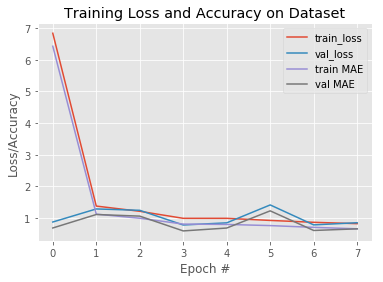

In [12]:
#N is the number of epochs
#plot code from https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
N = 8
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), modelHistory.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), modelHistory.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), modelHistory.history["mean_absolute_error"], label="train MAE")
plt.plot(np.arange(0, N), modelHistory.history["val_mean_absolute_error"], label="val MAE")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [13]:
historyDF = pd.read_csv("C:\\Users\\alegAsus\\Downloads\\SCUT-FBP5500_v2.1\\SCUT-FBP5500_v2\\saved models\\continous RMSE\\callbacks1 CM.log",header = 0)
historyDF.head(12)

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,6.834186,6.424435,0.878759,0.690565
1,1,1.381405,1.126700,1.290797,1.115405
2,2,1.216561,0.997607,1.247777,1.064274
3,3,0.994967,0.813145,0.784606,0.597634
4,4,0.994872,0.802021,0.852488,0.688653
5,5,0.928357,0.765704,1.417500,1.230693
6,6,0.869503,0.709715,0.788054,0.611674
7,7,0.826177,0.664244,0.855722,0.663109


The lowest MAE is achieved at epoch 10

In [14]:
historyDF['val_mean_absolute_error'].min()

0.5976338569323222

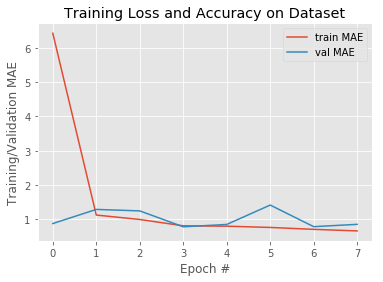

In [15]:
N = 8
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), historyDF.iloc[0:N, 2], label="train MAE")
plt.plot(np.arange(0, N), historyDF.iloc[0:N, 3], label="val MAE")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Training/Validation MAE")
plt.legend(loc="upper right")

In [25]:
imagesPredict = []
x = cv2.imread("C:\\Users\\alegAsus\\Downloads\\SCUT-FBP5500_v2.1\\SCUT-FBP5500_v2\\CM\\predict\\jonathan.jpg") #loading file
x = cv2.resize(x, (96, 96))
imagesPredict.append(x) #adding to x_train array

In [30]:
imagesNumPyPredict = np.array(imagesPredict, dtype="float") / 255.0

In [31]:
imagesNumPyPredict.shape

(1, 96, 96, 3)

In [32]:
model.predict(imagesNumPyPredict)

array([[5.247966]], dtype=float32)